In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
data_dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\Grapevine_Leaves_Image_Dataset'

In [5]:
os.listdir(data_dir)

['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

In [6]:
img_path = data_dir+'\\Ak\\'

In [7]:
from PIL import Image

def count_images(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.png'):
            count += 1
    return count

def analyze_images(folder_path):
    images = []
    sizes = []
    mean_colors = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                # Get image size
                images.append(img)
                width, height = img.size
                sizes.append((width, height))
                
                # Convert image to numpy array
                img_array = np.array(img)
                
                # Calculate mean color
                mean_color = img_array.mean(axis=(0, 1))
                mean_colors.append(mean_color)

    return images, sizes, mean_colors

def plot_distribution(sizes, mean_colors):
    # Plot size distribution
    widths, heights = zip(*sizes)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, alpha=0.7, label='Width')
    plt.hist(heights, bins=20, alpha=0.7, label='Height')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()

    # Plot color distribution
    mean_colors = np.array(mean_colors)
    plt.subplot(1, 2, 2)
    plt.hist(mean_colors[:, 0], bins=20, alpha=0.7, label='Red', color='red')
    plt.hist(mean_colors[:, 1], bins=20, alpha=0.7, label='Green', color='green')
    plt.hist(mean_colors[:, 2], bins=20, alpha=0.7, label='Blue', color='blue')
    plt.xlabel('Mean Color Value')
    plt.ylabel('Frequency')
    plt.title('Color Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()


Total number of images: 100


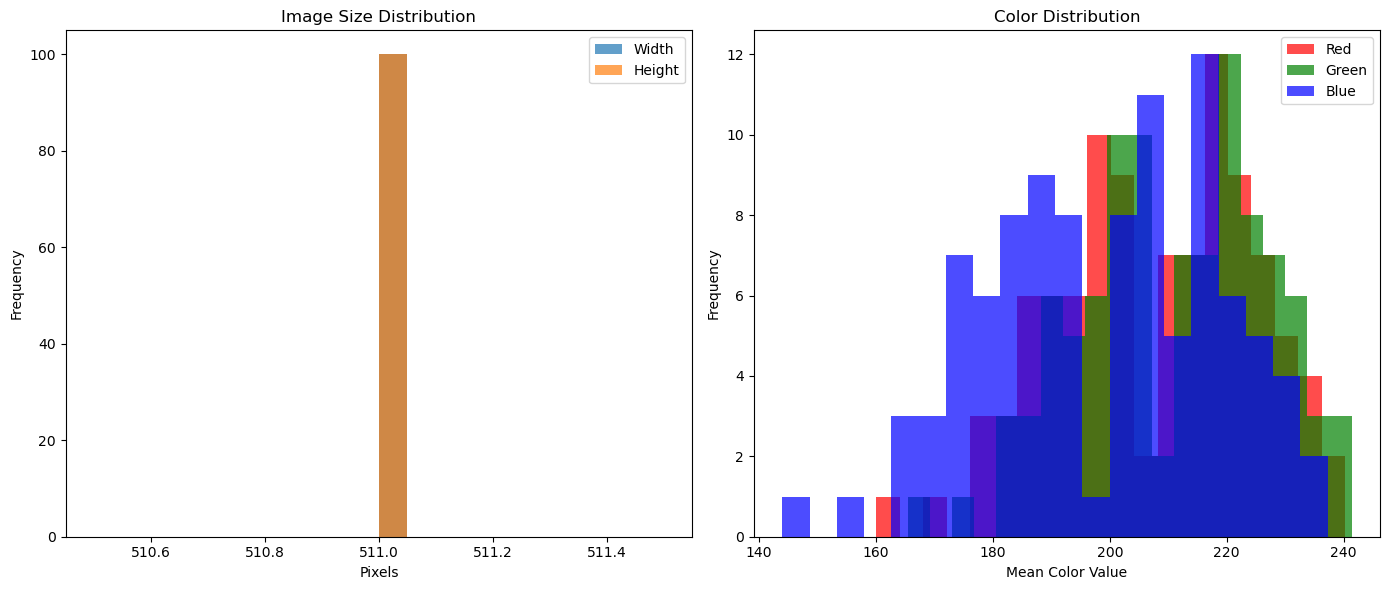

In [8]:
# Count the number of images
image_count = count_images(img_path)
print(f'Total number of images: {image_count}')

images, sizes, mean_colors = analyze_images(img_path)
plot_distribution(sizes, mean_colors)

In [9]:
# Image dimensions
#img_height, img_width = 250, 250
rescale_height, rescale_width = 224, 224
channels = 3  # RGB images

In [10]:
import cv2
from PIL import Image

def load_and_preprocess_images(image_list, img_height=56, img_width=56):
    images = []

    def detect_object_and_adjust(image):
        # Convert to numpy array
        img_array = np.array(image)
        # Convert to grayscale if the image has more than one channel
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        
        # Detect object (using a simple threshold-based method for example purposes)
        _, thresh = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) == 0:
            return image  # No object found, return original image
        
        # Find the largest contour which we'll assume is our object
        contour = max(contours, key=cv2.contourArea)
        
        # Get bounding rectangle for the largest contour
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Calculate the rotation angle to align the leaf
        angle = rect[2]
        if angle < -45:
            angle += 90
        
        # Rotate the original image to standard orientation
        rotated_img = cv2.warpAffine(img_array, cv2.getRotationMatrix2D(rect[0], angle, 1.0), (img_array.shape[1], img_array.shape[0]), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        
        # Find bounding box coordinates after rotation
        x, y, w, h = cv2.boundingRect(contour)
        
        # Expand the bounding box by 10 pixels on each side
        x_min = max(x - 10, 0)
        y_min = max(y - 10, 0)
        x_max = min(x + w + 10, rotated_img.shape[1])
        y_max = min(y + h + 10, rotated_img.shape[0])
        
        # Crop the image to the expanded bounding box
        cropped_img = rotated_img[y_min:y_max, x_min:x_max]
        
        # Resize the cropped image to the target dimensions
        resized_img = cv2.resize(cropped_img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
        
        return Image.fromarray(resized_img)

    for image in image_list:
        # Detect and adjust object
        img = detect_object_and_adjust(image)
        # Convert to numpy array
        img_array = np.array(img)
        # Normalize the images to the range [-1, 1]
        img_array = (img_array - 127.5) / 127.5
        images.append(img_array)

    images = np.expand_dims(np.array(images), axis=-1)  # Expand dimensions to add channel for grayscale

    # Convert to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    return images_tensor.numpy()


In [11]:
def load_and_preprocess_images(image_list, img_height=56, img_width=56):
    images = []

    def detect_object_and_adjust(image):
        # Convert to numpy array
        img_array = np.array(image)
        # Convert to grayscale if the image has more than one channel
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        
        # Detect object (using a simple threshold-based method for example purposes)
        _, thresh = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) == 0:
            return image  # No object found, return original image
        
        # Find the largest contour which we'll assume is our object
        contour = max(contours, key=cv2.contourArea)
        
        # Get bounding rectangle for the largest contour
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Calculate the rotation angle to align the leaf
        angle = rect[2]
        if angle < -45:
            angle += 90
        
        # Rotate the original image to standard orientation
        rotated_img = cv2.warpAffine(img_array, cv2.getRotationMatrix2D(rect[0], angle, 1.0), (img_array.shape[1], img_array.shape[0]), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        
        # Find bounding box coordinates after rotation
        x, y, w, h = cv2.boundingRect(contour)
        
        # Expand the bounding box by 10 pixels on each side
        x_min = max(x - 10, 0)
        y_min = max(y - 10, 0)
        x_max = min(x + w + 10, rotated_img.shape[1])
        y_max = min(y + h + 10, rotated_img.shape[0])
        
        # Crop the image to the expanded bounding box
        cropped_img = rotated_img[y_min:y_max, x_min:x_max]
        
        # Resize the cropped image to the target dimensions
        resized_img = cv2.resize(cropped_img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
        
        return Image.fromarray(resized_img)

    for image in image_list:
        # Detect and adjust object
        img = detect_object_and_adjust(image)
        # Convert to numpy array
        img_array = np.array(img)
        # Normalize the images to the range [-1, 1]
        img_array = (img_array - 127.5) / 127.5
        images.append(img_array)

    images = np.expand_dims(np.array(images), axis=-1)  # Expand dimensions to add channel for grayscale

    # Convert to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    return images_tensor.numpy()

In [12]:
# Load and preprocess images
post_images = load_and_preprocess_images(images, rescale_height, rescale_width)

C:\Users\kaizi\AppData\Local\Temp\ipykernel_11332\61834548.py:24: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [13]:
type(post_images[0])

numpy.ndarray

In [14]:
post_images.shape

(100, 224, 224, 1)

In [15]:
def plot_ori_images(images, num_images=20, title="Title"):
    num_rows = (num_images // 7) + 1  # Calculate number of rows needed
    plt.figure(figsize=(14, 2 * num_rows))  # Adjust figure size based on number of rows
    
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(num_rows, 7, i + 1)  # Adjust subplot position for multiple rows and 7 columns
        plt.imshow(images[i], cmap='gray')  # Display the image (assuming it's grayscale)
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_post_images(images, num_images=20, title="Title"):
    num_rows = (num_images // 7) + 1  # Calculate number of rows needed
    plt.figure(figsize=(14, 2 * num_rows))  # Adjust figure size based on number of rows
    
    for i in range(num_images):
        ax = plt.subplot(num_rows, 7, i + 1)  # Adjust subplot position for multiple rows and 7 columns
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

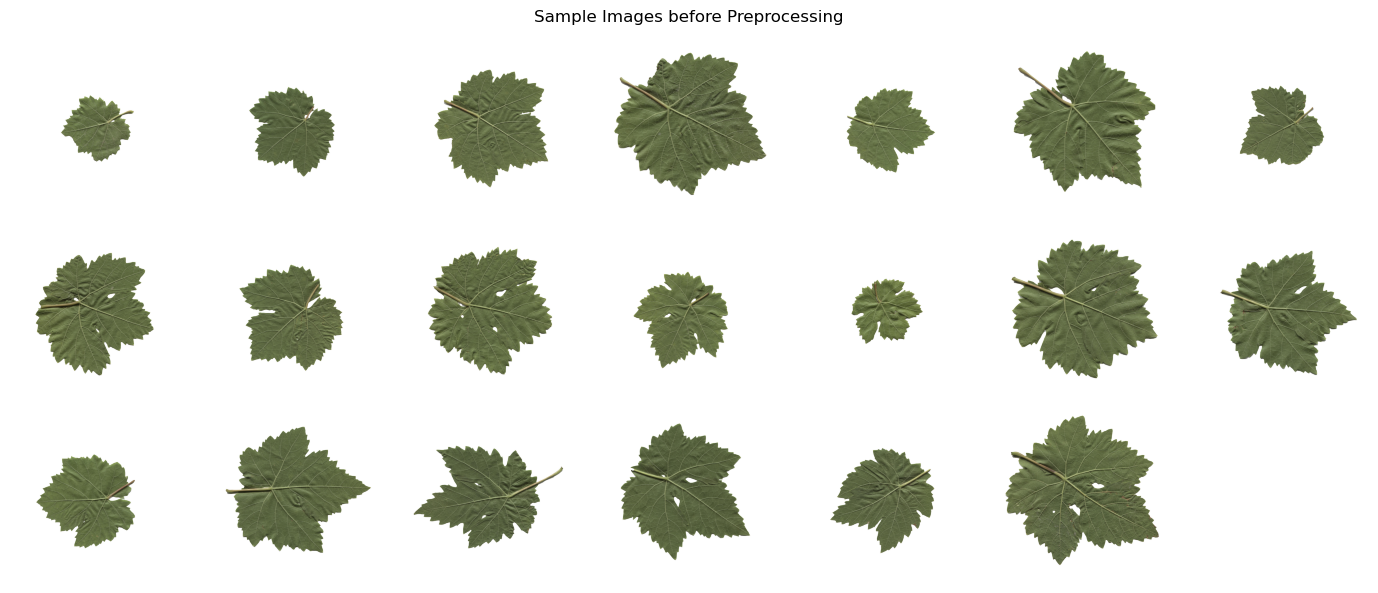

In [17]:
plot_ori_images(images, title="Sample Images before Preprocessing")

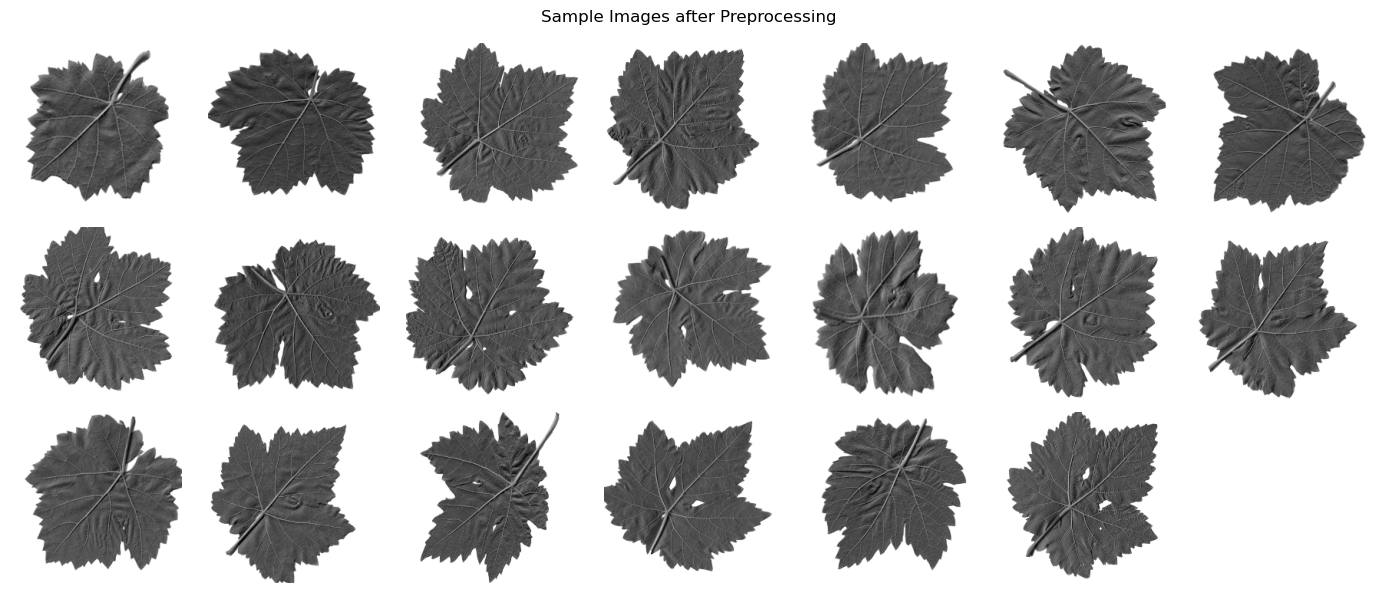

In [18]:
plot_post_images(post_images, title="Sample Images after Preprocessing")

In [19]:
def duplicate_and_shuffle_images(images_tensor, x, batch_size=1000):
    duplicated_images = []

    num_images = images_tensor.shape[0]
    for i in range(0, num_images, batch_size):
        batch = images_tensor[i:i + batch_size]
        batch_duplicated = np.repeat(batch, x, axis=0)
        duplicated_images.append(batch_duplicated)
    
    duplicated_images = np.concatenate(duplicated_images, axis=0)
    
    # Shuffle the duplicated images
    np.random.shuffle(duplicated_images)
    
    return duplicated_images

In [20]:
#post_images = duplicate_and_shuffle_images(post_images, 3)

In [21]:
post_images.shape

(100, 224, 224, 1)

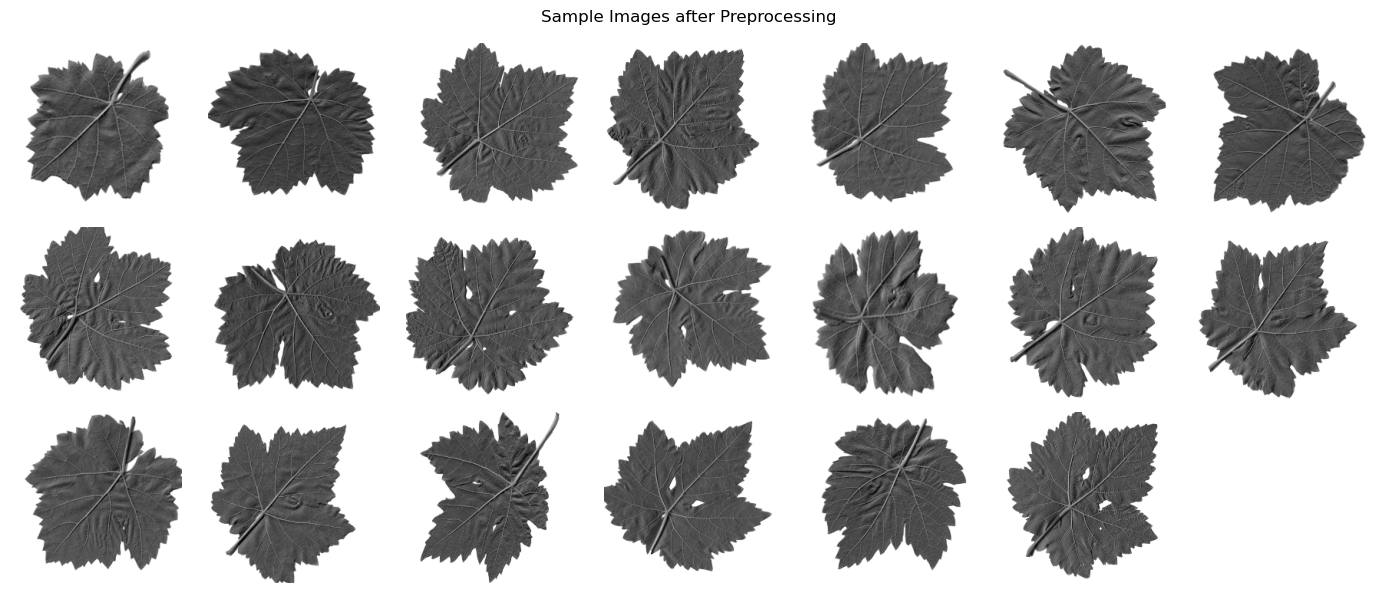

In [22]:
plot_post_images(post_images, title="Sample Images after Preprocessing")

## Generator and Discriminator

In [23]:
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from scipy.linalg import sqrtm

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
codings_size = 100

In [26]:
def calculate_fid(real_images, generated_images):
    """Calculate the FID score for grayscale images."""
    # Resize images to (75, 75)
    real_images_resized = tf.image.resize(real_images, (75, 75)).numpy()
    generated_images_resized = tf.image.resize(generated_images, (75, 75)).numpy()
    
    # Convert grayscale to RGB
    real_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(real_images_resized))
    generated_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(generated_images_resized))
    
    # Scale images to [0, 255]
    real_images_rescaled = (real_images_rgb * 127.5 + 127.5).numpy().astype('float32')
    generated_images_rescaled = (generated_images_rgb * 127.5 + 127.5).numpy().astype('float32')
    
    # Calculate activations
    model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3), weights=None)
    act1 = model.predict(real_images_rescaled)
    act2 = model.predict(generated_images_rescaled)
    
    # Calculate mean and covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # Calculate FID score
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [27]:
generator = Sequential()
generator.add(Dense(56 * 56 * 128, input_shape=[codings_size]))
generator.add(Reshape([56, 56, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))

generator.summary()

C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 401408)              │      40,542,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 112, 112, 128)       │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 224, 224, 1)         │           3,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,956,161 (156.24 MB)

 Trainable params: 40,955,649 (156.23 MB)

 Non-trainable params: 512 (2.00 KB)

In [28]:
discriminator = Sequential()
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                         activation=LeakyReLU(0.3),
                         input_shape=[rescale_height, rescale_width, 1]))
#discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding="same",
                         activation=LeakyReLU(0.3)))
#discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

C:\Users\kaizi\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 128)       │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 802816)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         802,817 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,601 (6.20 MB)

 Trainable params: 1,625,601 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.optimizers import Adam

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [30]:
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │      40,956,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ ?                           │       1,625,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,581,762 (162.44 MB)

 Trainable params: 40,955,649 (156.23 MB)

 Non-trainable params: 1,626,113 (6.20 MB)

In [31]:
# Training the GAN
batch_size = 32

In [32]:
dataset = tf.data.Dataset.from_tensor_slices(post_images).shuffle(buffer_size=1000)

In [33]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

### Training

In [34]:
epochs = 65
fid_scores = []
generator, discriminator = gan.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
#         if i%2 == 0:
#             print(f"\tTraining on batch number {i} of {len(images)//batch_size}")
        
        ## TRAINING DISCRIMINATOR
       
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Generate numbers based just on noise input
        gen_images = generator(noise)

        # Concatenate Generated Images against the Real Ones
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        discriminator.trainable = True

        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)

        ## TRAINING GENERATOR   

        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Allow discriminator to believe that fake images are real
        y2 = tf.constant([[1.]] * batch_size)

        discriminator.trainable = False

        gan.train_on_batch(noise, y2)
    
    # Evaluate FID
#     noise = tf.random.normal(shape=[1000, codings_size])
#     generated_images = generator(noise)
#     real_images = next(iter(dataset))[:1000]

#     fid = calculate_fid(real_images, generated_images)
#     fid_scores.append(fid)
#     print(f"Epoch {epoch+1} FID: {fid}")
    
print("COMPLETED")

Currently on Epoch 1
Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
Currently on Epoch 21
Currently on Epoch 22
Currently on Epoch 23
Currently on Epoch 24
Currently on Epoch 25
Currently on Epoch 26
Currently on Epoch 27
Currently on Epoch 28
Currently on Epoch 29
Currently on Epoch 30
Currently on Epoch 31
Currently on Epoch 32
Currently on Epoch 33
Currently on Epoch 34
Currently on Epoch 35
Currently on Epoch 36
Currently on Epoch 37
Currently on Epoch 38
Currently on Epoch 39
Currently on Epoch 40
Currently on Epoch 41
Currently on Epoch 42
Currently on Epoch 43
Currently on Epoch 44
Currently on Epoch 45
Currently on Epoch 

In [35]:
# epochs = 50
# for epoch in range(epochs):
#     print(f"Currently on Epoch {epoch+1}")
#     for X_batch in dataset:
#         # Train discriminator
#         noise = tf.random.normal(shape=[batch_size, codings_size])
#         gen_images = generator(noise)
#         X_fake_vs_real = tf.concat([gen_images, tf.cast(X_batch, tf.float32)], axis=0)
#         y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
#         discriminator.trainable = True
#         discriminator.train_on_batch(X_fake_vs_real, y1)

#         # Train generator
#         noise = tf.random.normal(shape=[batch_size, codings_size])
#         y2 = tf.constant([[1.]] * batch_size)
#         discriminator.trainable = False
#         gan.train_on_batch(noise, y2)
    
# print("COMPLETED")

In [36]:
# def plot_fid():
#     # Plot FID scores vs epochs
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(1, epochs + 1), fid_scores, marker='o', linestyle='-', color='b')
#     plt.title('FID Scores over Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('FID Score')
#     plt.grid(True)
#     plt.show()

In [37]:
#plot_fid()

In [38]:
def plot_gen_images(images, num_images=5, title='Generated Images', save_path=None):
    num_cols = 7  # Number of images per row
    num_rows = (num_images - 1) // num_cols + 1  # Calculate number of rows needed
    
    plt.figure(figsize=(15, num_rows * 3))  # Adjusted size for better visibility
    for i in range(num_images):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # Convert tensor to numpy array and squeeze to remove extra dimensions
        image = images[i].numpy().squeeze()
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
        # Save the individual image if save_path is provided
        if save_path:
            plt.imsave(os.path.join(save_path, f'image_{i}.png'), image, cmap='gray')
    
    plt.suptitle(title)
    plt.show()

In [39]:
def generate_and_plot_images(generator, codings_size, num_images=20, save_images=False, save_path=None):
    noise = tf.random.normal(shape=[num_images, codings_size])
    gen_images = generator(noise)
    
    if save_images and save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
    
    plot_gen_images(gen_images, num_images, title='Generated Images after Training', save_path=save_path)

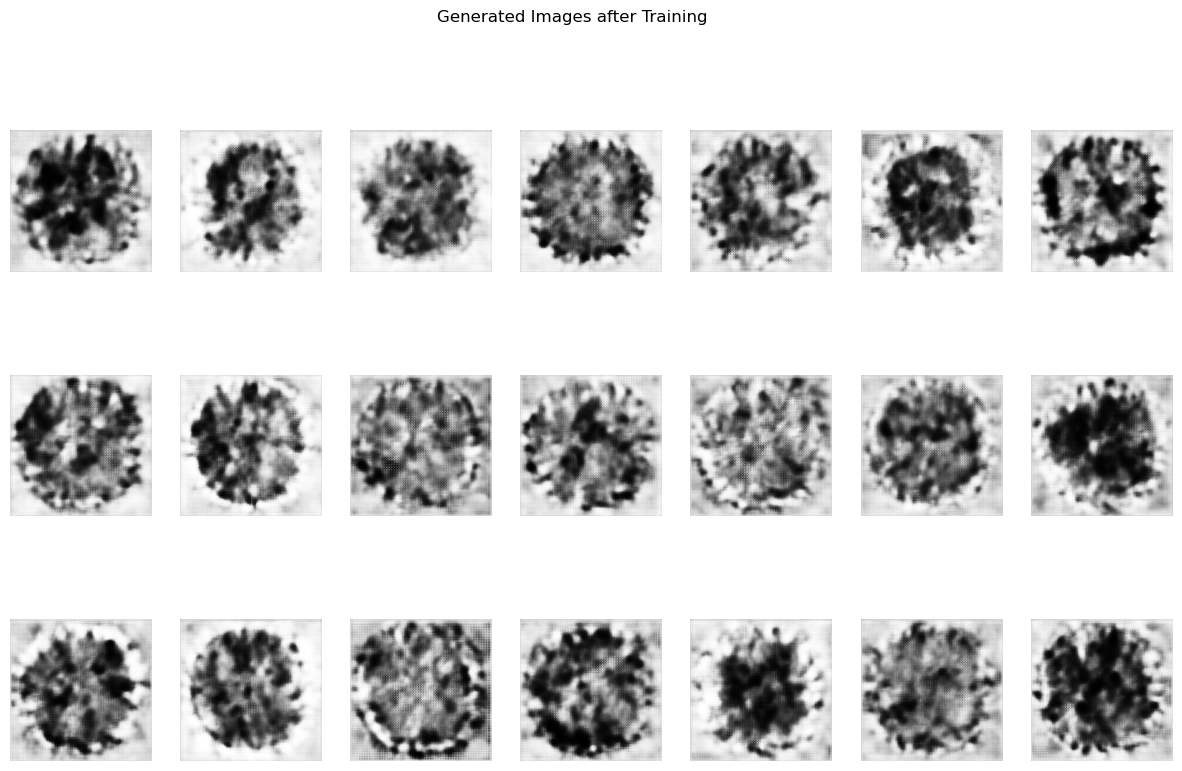

In [40]:
# Generate and save images
save_path = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\Fake_Vine_Images\\Ak'
generate_and_plot_images(generator, codings_size, num_images=21, save_images=True, save_path=save_path)